# RF Power Broadening in PPM Sample - Post Analysis


  * Oct 26 2022
  * CWODMR
  * -35 micron from surface
  * 39 microW laser
  * $T_{2}^{*} \approx 2.38 (5) \mu s$ 


The following demonstrates the broadening of spectral lines in the electronic states of an NV^-1 center in diamond, caused by increasing RF magnetic field power, which controls the transition betweent the ground and excited spin states. 

In the ppm sample used here, two RF-induced resonances were observed about the expected central zero-field split of 2.87 GHz. The double-peak was found for all values of RF power tested. 

This approach uses CW ODMR to measure the reduction in PL as a function of RF frequency and power. For each frequency scan at a particular power, a triple lorentzian was fit to the data and the width of the lorenztians were estimated. 
By varying the RF power, a clear trend of increased line width with increased power was observed.
Extrapolation to zero RF power suggests a minimum line width of 0.42(1) MHz, which corresponds to a driven decoherence time of $T_{2}^{*} \approx 2.38(5) \mu s$  for this sample.




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import optimize
import copy
from scipy.optimize import leastsq
import scipy 

import logging


In [3]:
import pickle
def save_file(name, data):
    with open(name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_file(name):
    with open(name, 'rb') as handle:
        return pickle.load(handle)

In [17]:
def plot_contrast_scan(scan, xlabel = 'frequency [Hz]', figsize = (10,6), marker = 'o-'):
    scan = np.array(scan)

    x_data = scan[:, 0]
    y_data = scan[:, 1]

    plt.figure(figsize=figsize)
    plt.plot(x_data, y_data, marker, label='Data')

    plt.xlabel(xlabel)

In [102]:
# some fitting functions

def lorentzian( x, center, amplitude, width ):
    return amplitude * width**2 / ( width**2 + ( x - center )**2)

def multi_lorentz( x, *params ):
    off = params[0]
    paramsRest = params[1:]
    assert not ( len( paramsRest ) % 3 )
    return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

def _2_lorentz_fixed_peak_diff(x, *params):
        offset = params[0]
        return offset + lorentzian(x, params[1], params[2], params[3]) + lorentzian(x, params[1] + params[4], params[5], params[6])

    
def _3_lorentz_same_amp_and_width(x, *params):
    output = params[0]
    output += lorentzian(x, params[1], params[2], params[3])
    output += lorentzian(x, params[4], params[2], params[3])
    output += lorentzian(x, params[5], params[2], params[3])
    return output

    
def res_multi_lorentz(xData, yData, *params):
    diff = [ multi_lorentz( x, *params ) - y for x, y in zip( xData, yData ) ]
    return diff



In [126]:
#more fitting stuff

def get_double_pars(p_opt, p_covariance):
    p_errors = np.sqrt(np.diag(p_covariance))

    offset = p_opt[0]
    offset_err = p_errors[0]

    pars_1 = p_opt[1:4]
    errs_1 = p_errors[1:4]
    pars_2 = p_opt[4:7]
    errs_2 = p_errors[4:7]
    
    mean_width  =  np.mean([pars_1[2], pars_2[2]])
    
    return offset, pars_1, pars_2, errs_1, errs_2, mean_width

def fit_double_lorentz(x, y, amp1 = 3, amp2 = 3, cen1 = 2865, cen2 = 2875, wid1 = 10, wid2 = 10, fixed_delta = None):

    params = [0, cen1, amp1, wid1, cen2, amp2, wid2]
    bounds = (0, np.inf)
    
    fit_function = multi_lorentz
    
    if fixed_delta is not None:
        params[4] = fixed_delta
        bounds = (len(params)*[0], len(params)*[np.inf])
        bounds[0][4] = params[4]-1e-10
        bounds[1][4] = params[4]+1e-10
        fit_function = _2_lorentz_fixed_peak_diff
        
    p_opt, p_cov = scipy.optimize.curve_fit(fit_function, x, y, 
                                            p0=params, 
                                            maxfev = 10000, 
                                            bounds = bounds)
    return p_opt, p_cov

# def get_triple_pars(p_opt, p_covariance):
#     p_errors = np.sqrt(np.diag(p_covariance))

#     offset = p_opt[0]
    
#     pars_1 = p_opt[1:4]
#     errs_1 = p_errors[1:4]
#     pars_2 = p_opt[4:7]
#     errs_2 = p_errors[4:7]
#     pars_3 = p_opt[7:10]
#     errs_3 = p_errors[7:10]
    
#     mean_width  =  np.mean([pars_1[2], pars_2[2], pars_3[2]])
    
#     return offset, pars_1, pars_2, errs_1, errs_2, pars_3, errs_3, mean_width

def fit_triple_lorentz(x, y, amp1 = 1, cen1 = 2778, cen2 = 2782, cen3 = 2786, wid1 = 10):

    params = [0, cen1, amp1, wid1, cen2, cen3]
    bounds = (len(params)*[-np.inf], len(params)*[np.inf])
    
    bounds[0][1], bounds[1][1] = 2765, 2800
    bounds[0][4], bounds[1][4] = 2765, 2800
    bounds[0][5], bounds[1][5] = 2765, 2800
    
    bounds[0][2], bounds[1][2] = 0, 20
    bounds[0][3], bounds[1][3] = 0, 20


    p_opt, p_cov = scipy.optimize.curve_fit(_3_lorentz_same_amp_and_width, x, y, 
                                            p0=params, 
                                            maxfev = 10000, 
                                            bounds = bounds)
    return p_opt, p_cov


In [99]:
def fit_scans(line_widths, fixed_delta = None):

    for a_pow, res in line_widths.items():
        print(a_pow)
      
        scan_data = res['scan']
        
        
        xData = scan_data[:, 0]*1e-6 #in MHz
        yData = scan_data[:, 1]

        #drop nans from the data
        xData = xData[~np.isnan(yData)]
        yData = yData[~np.isnan(yData)]

        yData = 1 - yData
        yData = yData*100
    
        optimized_p, cov_p = fit_triple_lorentz(xData, yData)

        p_errs = np.sqrt(np.diag(cov_p))
        offset = optimized_p[0]
        mean_width = optimized_p[3]
        line_width_sigma = p_errs[3]
        print(optimized_p)
        
        line_widths[a_pow].update({'p_opt': optimized_p,
                              'p_cov':cov_p,
                              'mean_width':mean_width,
                              'mean_width_sigma':line_width_sigma,
                              'x':xData,
                              'y':yData,
                              'scan':scan_data,
                              'fixed_delta':fixed_delta})
        
    return line_widths


def plot_spectrum_and_accumulate_line_widths(line_widths):
    rf_power_line_width = []

    for a_pow, res in line_widths.items():
        fixed_delta = res.get('fixed_delta', None)
        opt_p = copy.deepcopy(res['p_opt'])
        if fixed_delta is not None:
            raise NotImplementedError("not yet supported")
        plot_fit(res['x'], res['y'], opt_p)
        plt.title(f'RF Power = {a_pow}, Line Width = {res["mean_width"]:0.2f} MHz')
        plt.xlabel('frequency [MHz]')
        plt.ylabel('PL loss [percent]')
        rf_power_line_width.append([a_pow, res['mean_width'], res['mean_width_sigma']])

    return rf_power_line_width

In [110]:
def plot_fit(x, y, p_opt):
    plt.figure(figsize=(10, 6))

    plt.plot(x, y, 'o-', label='Data')
    plt.plot(x, _3_lorentz_same_amp_and_width(x, *p_opt), 'k--', label='Fit')
    plt.legend()

# Confocal Scan


In [8]:
scan_file = 'large_scan_x0t80_y0t80.npy'
confocal_scan = np.load(scan_file)

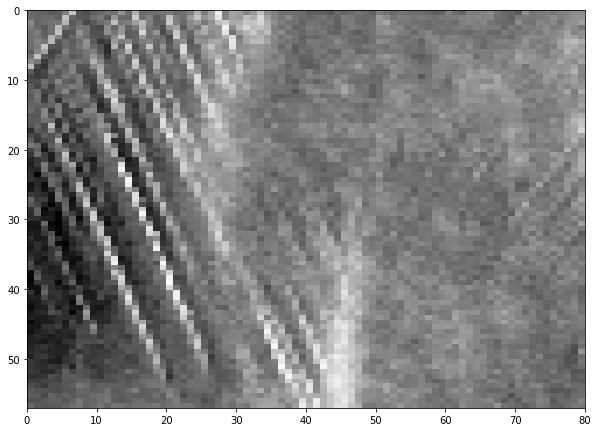

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(confocal_scan, cmap='Greys_r', extent = [0,80,57,0])

In [9]:
# selected position at (x = 60, y = 10)  Approximately 35 microns below the surface

In [10]:
save_data_name = 'rf_power_broadening_ppmsample_w_B_ext_cwodmr_4ms_single_orientation.oct26.2022.pickle'

line_widths_4ms_single_split = load_file(save_data_name)

In [24]:
sorted(line_widths_4ms_single_split.keys(),reverse=True)

[-5, -10, -15, -20, -22, -25, -28, -30, -32, -35, -38]

In [28]:
line_widths_4ms_single_split = {k:v for k,v in line_widths_4ms_single_split.items() if k != -15}

In [29]:
sorted(line_widths_4ms_single_split.keys(),reverse=True)

[-5, -10, -20, -22, -25, -28, -30, -32, -35, -38]

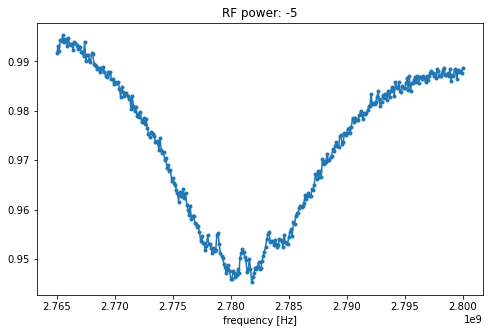

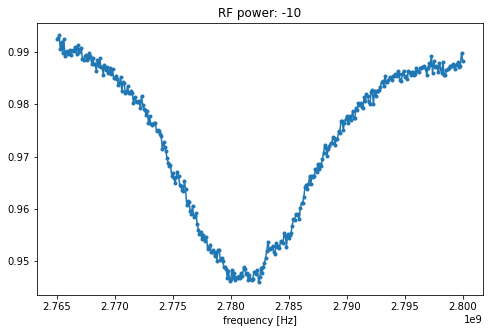

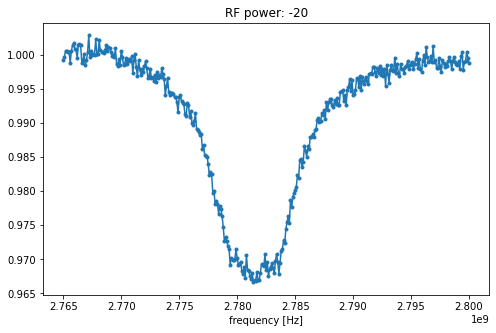

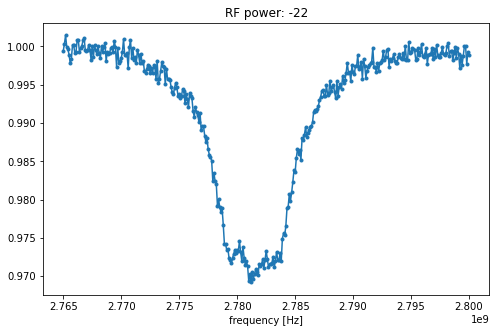

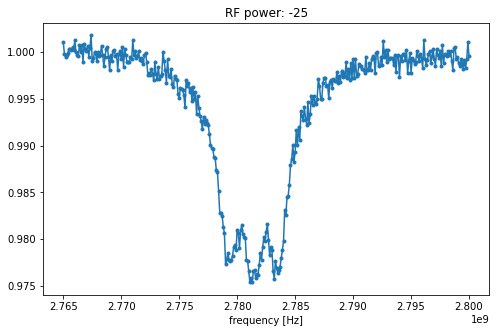

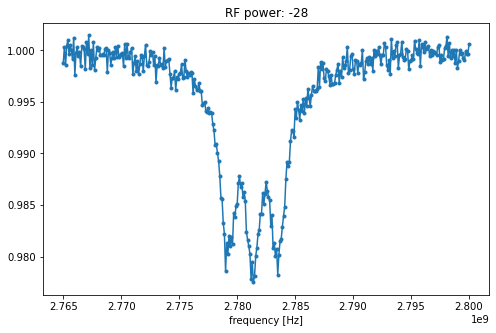

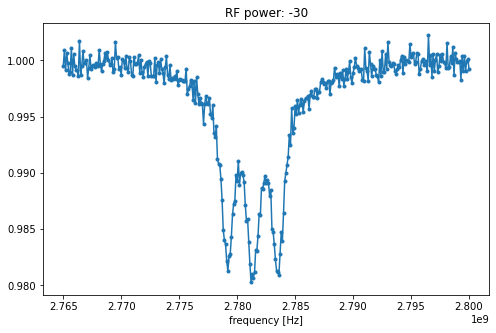

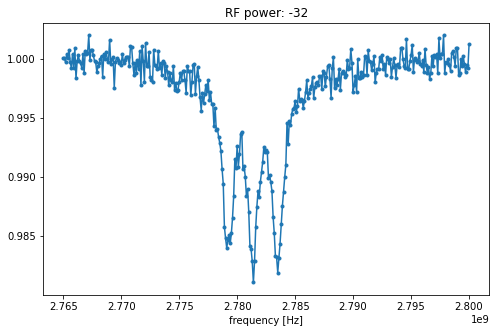

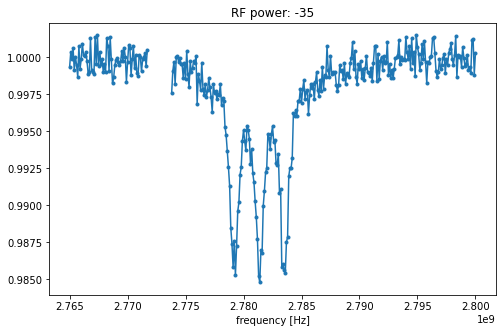

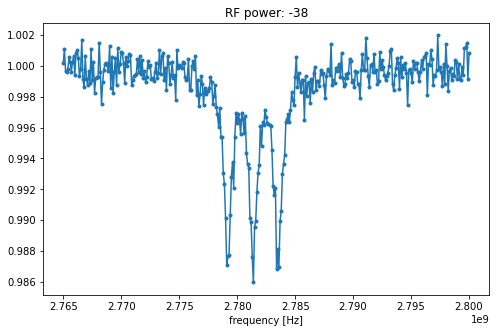

In [25]:
for a_pow in sorted(line_widths_4ms_single_split.keys(),reverse=True):
    res = line_widths_4ms_single_split[a_pow]
    if a_pow != -15:
        plot_contrast_scan(res['scan'],  figsize = (8,5), marker = '.-')
        plt.title(f'RF power: {a_pow}')


In [127]:
scans_with_fit_results = fit_scans(line_widths_4ms_single_split)

-5
[3.35361931e-01 2.78064028e+03 2.03386023e+00 5.42060147e+00
 2.77840192e+03 2.78569507e+03]
-10
[6.30109447e-01 2.78506990e+03 2.00734273e+00 4.67049262e+00
 2.77824993e+03 2.78096719e+03]
-25
[3.43991034e-02 2.78145068e+03 1.61675730e+00 1.26248090e+00
 2.78363998e+03 2.77915360e+03]
-20
[-6.96938701e-02  2.78157918e+03  1.60442021e+00  2.48272037e+00
  2.78385326e+03  2.77930207e+03]
-22
[3.97498048e-03 2.78374458e+03 1.60555724e+00 1.97413910e+00
 2.77918042e+03 2.78152640e+03]
-28
[4.95794987e-02 2.78359083e+03 1.62937794e+00 8.85096422e-01
 2.77913554e+03 2.78138578e+03]
-30
[4.31724978e-02 2.78137230e+03 1.58010795e+00 7.21704774e-01
 2.77914126e+03 2.78354917e+03]
-32
[4.15623507e-02 2.77919399e+03 1.47821305e+00 6.18432786e-01
 2.78136399e+03 2.78352680e+03]
-35
[3.47642596e-02 2.78353694e+03 1.29238189e+00 5.08555854e-01
 2.78137752e+03 2.77918934e+03]
-38
[2.55322152e-02 2.78137820e+03 1.16600490e+00 4.16653935e-01
 2.77918873e+03 2.78354374e+03]


In [128]:
scans_with_fit_results[-5].keys()

dict_keys(['scan', 'experiment_conditions', 'p_opt', 'p_cov', 'mean_width', 'mean_width_sigma', 'x', 'y', 'fixed_delta'])

In [129]:
for a_pow, res in scans_with_fit_results.items():
    print(res['p_opt'])

[3.35361931e-01 2.78064028e+03 2.03386023e+00 5.42060147e+00
 2.77840192e+03 2.78569507e+03]
[6.30109447e-01 2.78506990e+03 2.00734273e+00 4.67049262e+00
 2.77824993e+03 2.78096719e+03]
[3.43991034e-02 2.78145068e+03 1.61675730e+00 1.26248090e+00
 2.78363998e+03 2.77915360e+03]
[-6.96938701e-02  2.78157918e+03  1.60442021e+00  2.48272037e+00
  2.78385326e+03  2.77930207e+03]
[3.97498048e-03 2.78374458e+03 1.60555724e+00 1.97413910e+00
 2.77918042e+03 2.78152640e+03]
[4.95794987e-02 2.78359083e+03 1.62937794e+00 8.85096422e-01
 2.77913554e+03 2.78138578e+03]
[4.31724978e-02 2.78137230e+03 1.58010795e+00 7.21704774e-01
 2.77914126e+03 2.78354917e+03]
[4.15623507e-02 2.77919399e+03 1.47821305e+00 6.18432786e-01
 2.78136399e+03 2.78352680e+03]
[3.47642596e-02 2.78353694e+03 1.29238189e+00 5.08555854e-01
 2.78137752e+03 2.77918934e+03]
[2.55322152e-02 2.78137820e+03 1.16600490e+00 4.16653935e-01
 2.77918873e+03 2.78354374e+03]


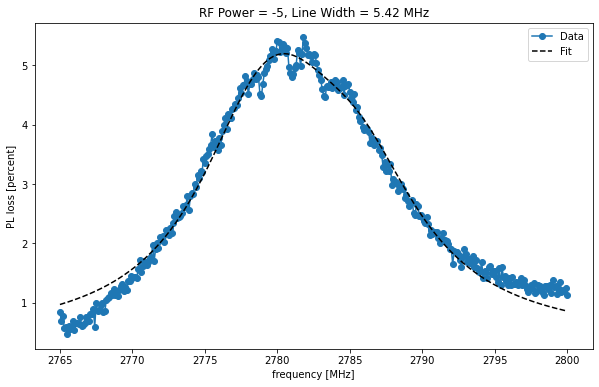

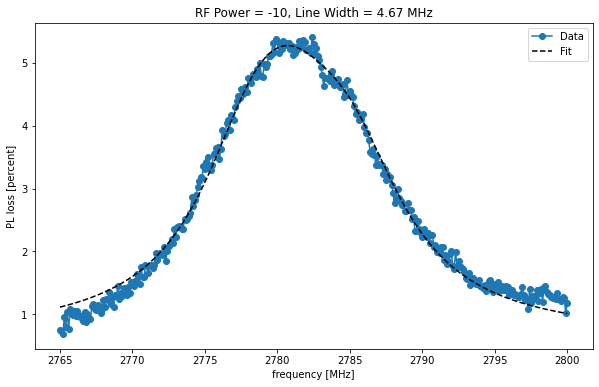

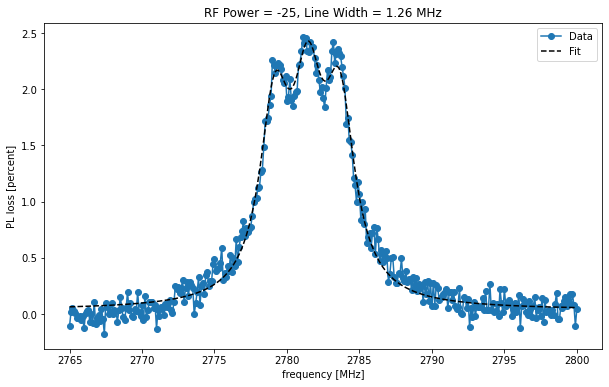

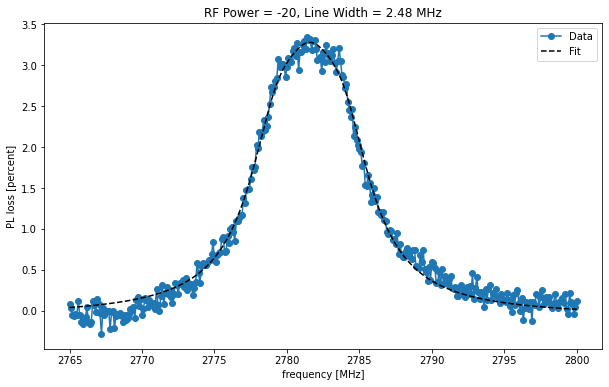

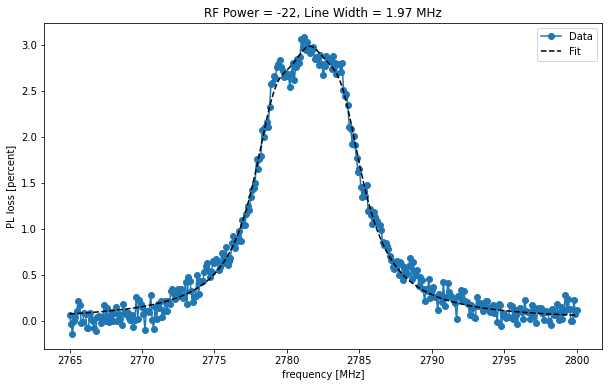

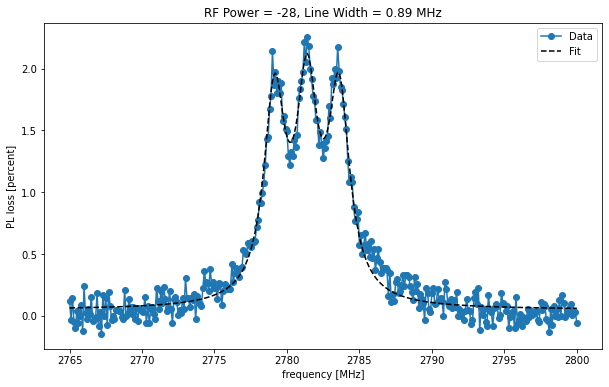

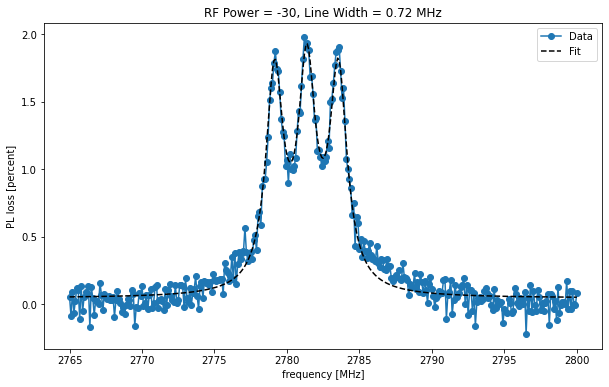

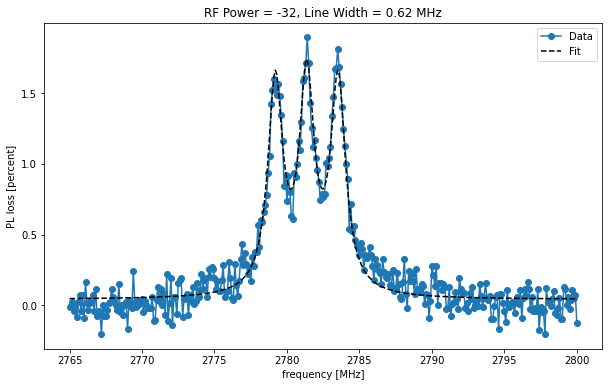

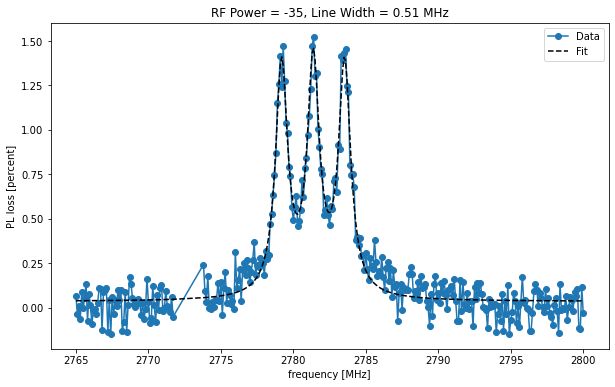

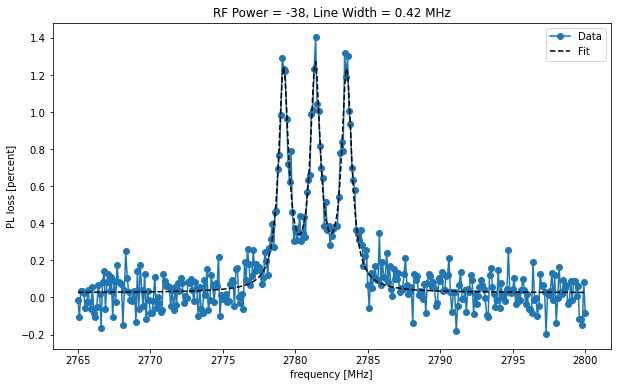

In [130]:
rf_power_broadening = plot_spectrum_and_accumulate_line_widths(scans_with_fit_results)

(0.0, 6.775751843450633)

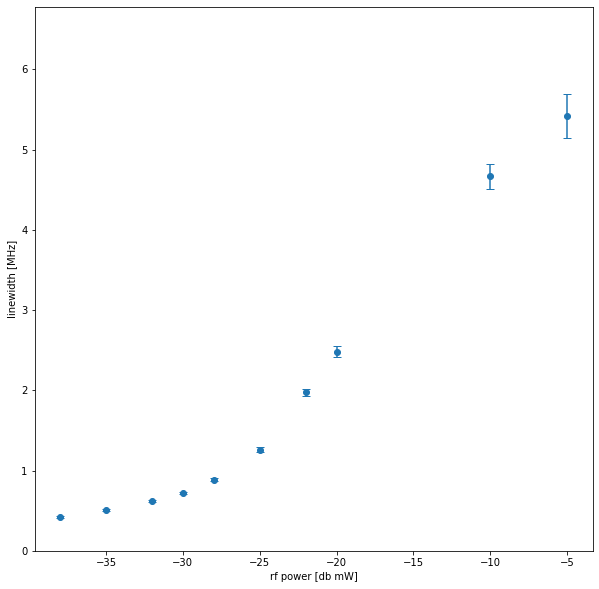

In [132]:
plt.figure(figsize=(10,10))
rf_power_broadening = np.array(rf_power_broadening)

#drop the last measurement as the data quality is very poor
#should add error bars to the estimated line widths
plt.errorbar(rf_power_broadening[:, 0], rf_power_broadening[:, 1], rf_power_broadening[:, 2],
             fmt = 'o', capsize = 4, label='Data')
plt.xlabel('rf power [db mW]')
plt.ylabel('linewidth [MHz]')
plt.ylim(0, max(rf_power_broadening[:, 1])*1.25)

In [134]:
rf_power_broadening

array([[-5.00000000e+00,  5.42060147e+00,  2.74375629e-01],
       [-1.00000000e+01,  4.67049262e+00,  1.54661302e-01],
       [-2.50000000e+01,  1.26248090e+00,  2.79368007e-02],
       [-2.00000000e+01,  2.48272037e+00,  7.04803442e-02],
       [-2.20000000e+01,  1.97413910e+00,  4.78437839e-02],
       [-2.80000000e+01,  8.85096422e-01,  1.77471486e-02],
       [-3.00000000e+01,  7.21704774e-01,  1.35230878e-02],
       [-3.20000000e+01,  6.18432786e-01,  1.42628765e-02],
       [-3.50000000e+01,  5.08555854e-01,  1.27133014e-02],
       [-3.80000000e+01,  4.16653935e-01,  1.23723895e-02]])